# Using Autoencoder as Anomaly Detection for FooBarChallenge

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import os

class ConvAutoencoder:
    # in this class, we are building a tensorflow model from scratch, thus,
    # (1) import all required layers
    # (2) add layers after the other (similar to cast method i.e. layer1(layer2))
    # (3) compile all layers and input into Sequential Model
    
    @staticmethod
    # similar to C# the staticmethod attribute allows the function to be called directly
    # i.e. ConvAutoencoder.build(foo)
    # rather than object = ConvAutoencoder, object.build(foo)
    
    def build(width, height, depth, filters=(32, 64), latentDim=32):
        # width, height, depth are inputs of image
        # filters are numbers of filters in the encoding and decoding portion. These are typically randomly distributed around mean 0
        # latentDimension is the encoded dimensionality
        
        inputShape = (height, width, depth)
        # channel dimensions is closely related to the input shape, as Keras could use different backend
        # the input could be (x,y,z,channels) or (channels,x,y,z)
        # in our case, we have explicitly call for channels to be last. why is this important? because
        # when we do batch normalization, we would have to call for which axis to be normalized
        chanDim = -1
        
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            # this is a 2 hidden layer neural network
            # 1st layer consists of 32 Conv2D kernels, followed by an Leaky ReLU activation function, then the batch is normalized
            # 2nd layer consists of 64 Conv2D kernels, followed by an Leaky ReLU activation function, then the batch is normalized
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # returns shape of final layer x (could be tuple, could be int). why is this important? because
        # we need to reconstruct the shape for decoder portion
        # flatten the network. When we flatten our network we have an effective (channel)(x)(y)(z) vector
        # then, we would use a dense matrix to force it to 16-elements vector
        volumeSize = K.int_shape(x)
        print(volumeSize)
        x = Flatten()(x)
        
        # final layer for the encoder portion 
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        
        # start building the decoder model which will accept the output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            # we reverse the number of filters to rebuild the original image size
            x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        
        return (encoder, decoder, autoencoder)

In [4]:
# script to build a dataset

import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
#import ConvAutoencoder
import argparse
import random
import pickle
import cv2

%matplotlib inline

def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):
    # data and labels are numpy array, validLabel and anomalyLabel is an integer for MNIST data
    # contam is the percentage which our dataset has anomalies
    # there is an assumption to which the data and labels are of the same size
    # since autoencoder are highly data-specific, any anomaly index can be used
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]
    
    # randomly shuffle both sets of indexes
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)
    
    # compute the total number of anomaly data points to select
    i = int(len(validIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]
    
    # use NumPy array indexing to extract both the valid images and "anomaly" images
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]
    
    # stack the valid images and anomaly images together to form a
    # single data matrix and then shuffle the rows
    images = np.vstack([validImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)
    # return the set of images
    return images

def visualize_predictions(decoded, gt, samples=10):
    # visualizing function for comparing original and decoded images
    # decoded is the image/prediction obtained from the autoencoder
    # gt is the test images
    
    # this is a cool trick here. Instantiate a "null" object then stack horizontally for the comparison
    # and stack vertically for comparison between samples
    outputs = None
    
    for i in range(0, samples):
        
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")
        
        output = np.hstack([original, recon])
        
        if outputs is None:
            outputs = output
        else:
            outputs = np.vstack([outputs, output])
    
    return outputs

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True, help="path to output dataset file")
#ap.add_argument("-m", "--model", type=str, required=True, help="path to output trained autoencoder")
#ap.add_argument("-v", "--vis", type=str, default="recon_vis.png", help="path to output reconstruction visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output plot file")
#args = vars(ap.parse_args())

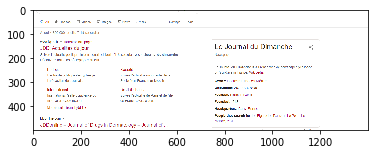

In [5]:
import cv2
import tensorflow as tf

y1 = 50
y2 = 500
x1 = 150
x2 = 1400
image = cv2.imread(r"C:\Users\Innovations\Desktop\AI\Trickception\Data\NotFoo\1125.png")
cropped = image[y1:y2,x1:x2]
plt.imshow(image)
# plt.imshow(cropped)
# print(image.shape)
# print(cropped.shape)
# resized = cv2.resize(cropped, (56,56))
# plt.imshow(resized)

cropped = tf.image.crop_to_bounding_box(image, y1,x1,y2,x2)
plt.imshow(cropped)

def decode_image(encoded, decoded, image_size=(56, 56)):
    bits = tf.io.read_file(encoded)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.crop_to_bounding_box(image, 50,150,500,1400)
    image = tf.image.resize(image, image_size)
    
    return image, image

In [6]:
PATH = r"C:\Users\Innovations\Desktop\AI\Trickception\Data\NotFoo"
fileList = [os.path.join(PATH, i) for i in os.listdir(PATH)]
trainPaths = fileList[:int(0.75*len(fileList))]
validPaths = fileList[int(0.75*len(fileList)):]

In [7]:
import tensorflow as tf
BATCH_SIZE = 128

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((trainPaths, trainPaths))
    .map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((validPaths, validPaths))
    .map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

[INFO] building autoencoder...
(None, 14, 14, 64)
Train for 8 steps, validate for 3 steps
Epoch 1/30
8/8 [==============================] - 21s 3s/step - loss: 0.2274 - val_loss: 0.2200
Epoch 2/30
8/8 [==============================] - 14s 2s/step - loss: 0.1481 - val_loss: 0.2096
Epoch 3/30
8/8 [==============================] - 14s 2s/step - loss: 0.0921 - val_loss: 0.1421
Epoch 4/30
8/8 [==============================] - 15s 2s/step - loss: 0.0594 - val_loss: 0.0895
Epoch 5/30
8/8 [==============================] - 14s 2s/step - loss: 0.0445 - val_loss: 0.0626
Epoch 6/30
8/8 [==============================] - 15s 2s/step - loss: 0.0381 - val_loss: 0.0482
Epoch 7/30
8/8 [==============================] - 14s 2s/step - loss: 0.0343 - val_loss: 0.0410
Epoch 8/30
8/8 [==============================] - 14s 2s/step - loss: 0.0309 - val_loss: 0.0379
Epoch 9/30
8/8 [==============================] - 14s 2s/step - loss: 0.0298 - val_loss: 0.0370
Epoch 10/30
8/8 [=============================

ValueError: x and y must have same first dimension, but have shapes (30,) and (24,)

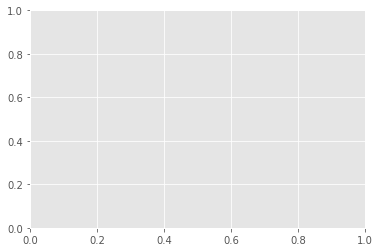

In [9]:
# initialize the number of epochs to train for, initial learning rate, and batch size
EPOCHS = 30
INIT_LR = 1e-3

print("[INFO] building autoencoder...")
# if we want to change to different image, change the following image size
(encoder, decoder, autoencoder) = ConvAutoencoder.build(56, 56, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
H = autoencoder.fit(train_dataset, validation_data=(valid_dataset), epochs=EPOCHS, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min")])

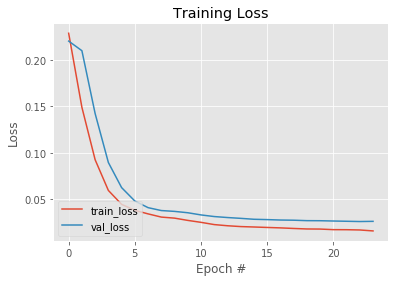

In [10]:
N = np.arange(0, 24)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
# serialize the image data to disk
#print("[INFO] saving image data...")
#f = open(args["dataset"], "wb")
#f.write(pickle.dumps(images))
#f.close()
# serialize the autoencoder model to disk
#print("[INFO] saving autoencoder...")
#autoencoder.save(args["model"], save_format="h5")

In [12]:
def decode_test_image(encoded, image_size=(56, 56)):
    bits = tf.io.read_file(encoded)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
#     image = tf.image.crop_to_bounding_box(image, 50,150,500,1400)
    image = tf.image.resize(image, image_size)
    
    return image

testImage = decode_test_image("C:/Users/Innovations/Desktop/AI/Trickception/FooExample.jpeg")
testImage = tf.expand_dims(testImage, axis=0)
result = autoencoder.predict(testImage, batch_size=1)

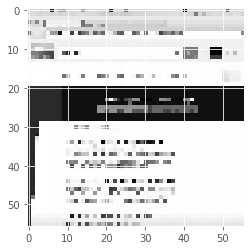

In [13]:
plt.imshow(testImage[0,:,:,0], cmap="gray")

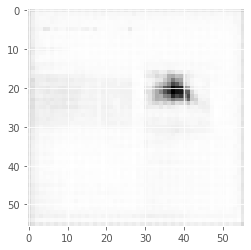

In [14]:
plt.imshow(result[0,:,:,0], cmap="gray")

In [15]:
np.mean((testImage - result)**2)

0.13570505

In [18]:
autoencoder.save("FooModel.h5")